In [1]:
import sqlite3
import pandas as pd

# Crear conexión a la base de datos
db_path = '../../Datos/Procesado/Preproc_Personality_Dataset.db'
con = sqlite3.connect(db_path)

# Cargar los datos en un DataFrame
df = pd.read_sql('SELECT * FROM personality_data', con)

# Cerrar la conexión
con.close()


In [12]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
db_path = '../../Datos/Procesado/Preproc_Personality_Dataset.db'
con = sqlite3.connect(db_path)
df = pd.read_sql('SELECT * FROM personality_data', con)
con.close()

# Verificar si las columnas 'Post_frequency' y 'Friends_circle_size' existen antes de eliminarlas
columns_to_drop = ['Post_frequency', 'Friends_circle_size']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Verificar que las columnas necesarias para X e y están presentes
required_columns = ['Personality', 'Personality_num']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"Las columnas necesarias no están en el DataFrame: {required_columns}")

# Preparar las características (X) y la variable objetivo (y)
X = df.drop(columns=[col for col in required_columns if col in df.columns])  # Eliminar las columnas no relevantes
y = df['Personality_num']  # Variable objetivo

# Normalizar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento (60%) y conjunto de validación + prueba (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

# Ahora dividir el conjunto temporal (40%) en validación (50%) y prueba (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [18]:
from sklearn.model_selection import GridSearchCV

# Definir el rango de hiperparámetros para probar
param_grid = {
    'C': [0.00001,0.0001,0.001,0.01, 0.1, 1, 10],  # Parámetro de regularización
    'solver': ['liblinear', 'saga'],  # Solvers disponibles para regresión logística
    'max_iter': [500, 1000, 2000]  # Iteraciones máximas para el entrenamiento
}

# Inicializar el modelo de regresión logística
log_reg = LogisticRegression()

# Inicializar GridSearchCV con validación cruzada (usamos el conjunto de validación aquí)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)

# Realizar la búsqueda de hiperparámetros usando el conjunto de validación
grid_search.fit(X_val, y_val)

# Ver los mejores parámetros encontrados
print(f"Mejores parámetros: {grid_search.best_params_}")

# Usar el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Entrenar el mejor modelo con los datos de entrenamiento
best_model.fit(X_train, y_train)



Fitting 3 folds for each of 42 candidates, totalling 126 fits
Mejores parámetros: {'C': 1e-05, 'max_iter': 500, 'solver': 'liblinear'}


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1e-05
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,500
,multi_class,'deprecated'


Validation Accuracy: 91.21%
Test Accuracy: 93.79%
Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       253
           1       0.95      0.90      0.92       327

    accuracy                           0.91       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.91      0.91      0.91       580

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       286
           1       0.94      0.94      0.94       294

    accuracy                           0.94       580
   macro avg       0.94      0.94      0.94       580
weighted avg       0.94      0.94      0.94       580



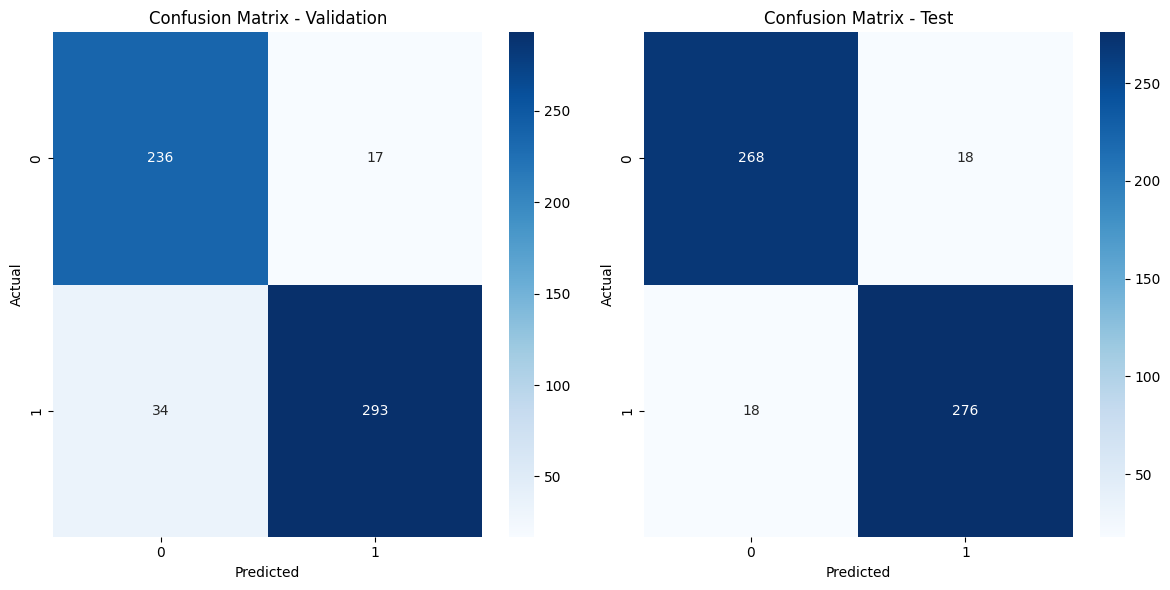

In [19]:
# Hacer predicciones sobre el conjunto de validación
y_val_pred = best_model.predict(X_val)

# Hacer predicciones sobre el conjunto de test
y_test_pred = best_model.predict(X_test)

# Evaluar el modelo sobre el conjunto de validación
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Evaluar el modelo sobre el conjunto de test
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Reporte de clasificación para validación
print("Classification Report (Validation):")
print(classification_report(y_val, y_val_pred))

# Reporte de clasificación para test
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))

# Graficar las matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Matriz de confusión para el conjunto de validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_, ax=axes[0])
axes[0].set_title("Confusion Matrix - Validation")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Matriz de confusión para el conjunto de prueba
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_, ax=axes[1])
axes[1].set_title("Confusion Matrix - Test")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [20]:
import joblib  # Importar joblib para guardar el modelo

# Guardar el modelo entrenado
model_save_path = '../../Datos/Modelado/modelo.joblib'  # Ruta para guardar el modelo
joblib.dump(best_model, model_save_path)

print(f"Modelo guardado en {model_save_path}")


Modelo guardado en ../../Datos/Modelado/modelo.joblib
